In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

/home/azureuser/MADS-exam-25/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-18 09:32:05,246	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [3]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Get the 1D data into a 2D matrix

In [4]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)

# Neem maar 20% van de normale samples
normal_indices = (traindataset.y == 0).nonzero().squeeze()
keep_indices = normal_indices[torch.randperm(len(normal_indices))[:len(normal_indices)//5]]
other_indices = (traindataset.y != 0).nonzero().squeeze()

# Combineer
all_indices = torch.cat([keep_indices, other_indices])
traindataset.x = traindataset.x[all_indices]
traindataset.y = traindataset.y[all_indices]

traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

print(f"New distribution: {torch.bincount(traindataset.y)}")

New distribution: tensor([14494,  2223,  5788,   641,  6431])


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(0))

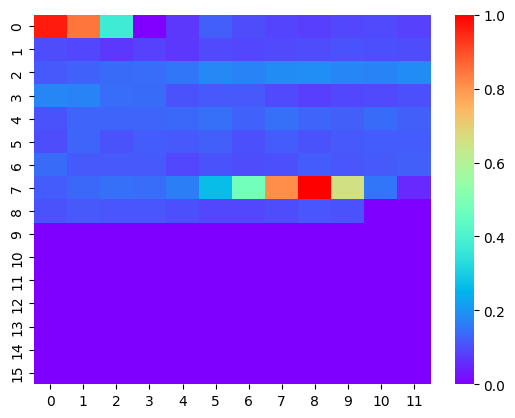

In [5]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [6]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(924, 684)

In [7]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

`mltrainer` provides a ConvBlock, which makes it easier to stack block in the model.
It also provides an architecture inspired by AlexNet (2012) which is used as a starting point for image classification.

Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, or even vision transformers (eg see [torch docs](https://docs.pytorch.org/tutorials/beginner/vt_tutorial.html#classifying-images-with-deit) ) 
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [8]:
from mltrainer.imagemodels import CNNConfig, CNNblocks

In [9]:
config = CNNConfig(
    matrixshape=shape,
    batchsize=32,
    input_channels=1,
    hidden=32,
    kernel_size=3,
    maxpool=2,
    num_layers=2,
    num_classes=5,
)
model = CNNblocks(config)
model(x).shape

Calculated matrix size: 48
Caluclated flatten size: 1536


torch.Size([32, 5])

In [10]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [11]:
config.__dict__

{'matrixshape': (16, 12),
 'batchsize': 32,
 'input_channels': 1,
 'hidden': 32,
 'kernel_size': 3,
 'maxpool': 2,
 'num_layers': 2,
 'num_classes': 5}

Read [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) about micro and macro F1 scores.


In [12]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [14]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam_v2.db")
mlflow.set_experiment("2D alexnet with sampling")

2025/06/18 09:35:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/06/18 09:35:05 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/azureuser/MADS-exam-25/notebooks_adriaan/mlruns/1', creation_time=1750239309289, experiment_id='1', last_update_time=1750239309289, lifecycle_stage='active', name='2D alexnet with sampling', tags={}>

In [15]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5,
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config.__dict__)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2025-06-18 09:35:12.487 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to logs/heart2D/20250618-093512
100%|██████████| 184/184 [00:03<00:00, 51.25it/s]
2025-06-18 09:35:26.000 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.2770 test 1.0354 metric ['0.6261', '0.6261', '0.3467', '0.6261', '0.4872']
100%|██████████| 184/184 [00:03<00:00, 54.88it/s]
2025-06-18 09:35:31.695 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.7633 test 0.3352 metric ['0.9189', '0.9189', '0.6470', '0.9189', '0.6741']
100%|██████████| 184/184 [00:03<00:00, 49.51it/s]
2025-06-18 09:35:37.814 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.4914 test 0.3255 metric ['0.9306', '0.9306', '0.7392', '0.9306', '0.8334']
100%|██████████| 184/184 [00:03<00:00, 54.06it/s]
2025-06-18 09:35:43.573 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.3642 test 0.2108 metric ['0.9391', '0.9391', '0.7776', '0.9391', '0.8664']
100%|██████████| 184/184 [00:03<00:00, 49.09it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

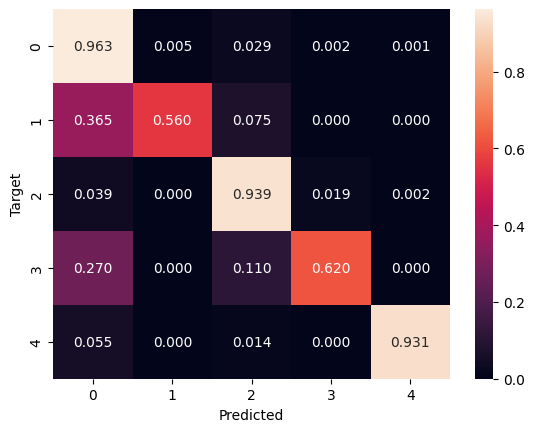

In [16]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")